In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import  os
import happi
import math

# 拟合
from scipy import interpolate as intp
from numpy import polyfit, poly1d

# 傅里叶变换和滤波
from scipy.fftpack import fft,ifft,fftshift,fft2
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

from scipy.io import savemat

pi = math.pi


In [2]:
#打开磁场数据
path = os.getcwd()

#Open a Scalar diagnostic
S = happi.Open(path)

Loaded simulation '/media/ustcxp/C14D581BDA18EBFA/research/MS_wave/new/2dshell_coldIonTem/cell_size/tst02'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for RadiationSpectrum diagnostics
Scanning for Performance diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics


In [3]:
Uelm_Bx_m = S.Scalar('Uelm_Bx_m').getData()
#验证归一化后的单位
print("Uelm_Bx_m[t=0] = ",{Uelm_Bx_m[0]})
B0 = Bx = 2./3
lambda_i = 10
Lx = 102.4*lambda_i
Ly = 25.6*lambda_i
Nx = 512
Ny = 256
dx = int(Lx/Nx)
dy = int(Ly/Ny)
init_UBx_m = 0.5 * B0**2 * dx * dy *(Nx+1)*(Ny+2) 
print("The inital Uelm_Bx_m is ",{init_UBx_m})
c = 1
dt = 0.001

Uelm_Bx_m[t=0] =  {58824.0}
The inital Uelm_Bx_m is  {58824.0}


In [4]:
step = 5
#read field0
Bx = np.array(S.Field(0,'Bx').getData())
Bx = Bx[::step,:,:]-B0

By = np.array(S.Field(0,'By').getData())
By = By[::step,:,:]

Bz = np.array(S.Field(0,'Bz').getData())
Bz = Bz[::step,:,:]

Ex = np.array(S.Field(0,'Ex').getData())
Ex = Ex[::step,:,:]

Ey = np.array(S.Field(0,'Ey').getData())
Ey = Ey[::step,:,:]

Ez = np.array(S.Field(0,'Ez').getData())
Ez = Ez[::step,:,:]

t_steps = np.array(S.Field(0,'Bx').getTimesteps())
time0 = t_steps[::step] * dt

In [5]:
from numpy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq

# 假设输入：
# Bx: shape (Nt, Nx, Ny)
# dx, dy: spatial sampling intervals in x and y (same units as coordinates)
# angle_cut_deg: 45 for your case
# forward_only: if True, keep only kx > 0 (波沿 x 正向传播)，否则保留正负 kx

def para_spatial_directional_filter(B, dx, dy, angle_cut_deg, forward_only=False,
                               smooth_width_k=0.0):
    """
    对每一帧（每个时间步）在 (x,y) 做 2D FFT，按 k 空间的角度筛选分量，然后逆变换回物理空间。
    参数:
      B: np.array shape (Nt, Nx, Ny)
      dx, dy: spacing in x and y
      angle_cut_deg: 允许的最大夹角（度）
      forward_only: 如果 True，只保留 kx > 0 的分量（即只保留向 +x 的传播）
      smooth_width_k: 在 k-space 中边缘平滑带宽（以 k 的单位，0 表示硬截断；>0 使用余弦窗/软边界）
    返回：
      B_filtered: same shape as B, 实数
    """
    Nt, Nx, Ny = B.shape
    # k 轴（以周期/单位长度为单位）；如果你更喜欢用 rad/m 请乘以 2π
    kx_vals = fftfreq(Nx, d=dx)   # shape (Nx,)
    ky_vals = fftfreq(Ny, d=dy)   # shape (Ny,)

    # 构造网格（注意顺序：kx 为行，对应 x 维，ky 为列，对应 y 维）
    kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals, indexing='ij')  # shape (Nx, Ny)

    # 计算角度：角度相当于 atan2(|ky|, |kx|)
    angle_rad = np.arctan2(np.abs(ky_grid), np.abs(kx_grid))  # 0..pi/2
    angle_cut_rad = np.deg2rad(angle_cut_deg)

    # 基本掩码（硬阈值）
    mask = (angle_rad <= angle_cut_rad)

    # 如果需要只保留正向 kx：
    if forward_only:
        mask = mask & (kx_grid > 0)

    # 可选：对掩码做平滑边界（soft mask），避免锐利截断导致振铃
    if smooth_width_k > 0.0:
        # 计算距离到边界的“过渡量”。这里用基于 angle 的差值作为示例 
        # （也可以用径向距离 |k| 或直接对角度做平滑）
        delta_angle = angle_rad - angle_cut_rad
        # 在过渡宽度内做余弦软窗：当 delta_angle <= -w -> 1; >= w -> 0; 中间平滑
        # 需要将 smooth_width_k（以 k 单位）转换为角度近似：这里做简化，将 smooth_width_k 解释为角度宽度（弧度）
        w = smooth_width_k
        soft = 0.5 * (1.0 - np.sin(np.clip(delta_angle / (w + 1e-12), -1.0, 1.0) * (np.pi / 2)))
        # soft ∈ [0,1], 当 delta_angle << -w -> close to 1 (keep)，当 >> w -> close to 0 (remove)
        mask = mask.astype(float) * soft

    # 预分配输出
    B_filt = np.zeros_like(B, dtype=np.float64)

    # 为减少周期化边缘效应，建议在这里对每个切片做 window 或 pad。下面示例只做硬变换（简单版）。
    for t in range(Nt):
        slice_xy = B[t]  # shape (Nx, Ny), 实数
        # 2D FFT
        F = fft2(slice_xy)
        F_shifted = fftshift(F)   # 将零频搬到中心，使得 kx_grid,ky_grid 也可以对应中心化视图
        # Note: kx_grid, ky_grid built with fftfreq correspond to unshifted ordering.
        # If using fftshift on F, we should also fftshift the k-grid for masking:
        F_masked = F_shifted * fftshift(mask)
        # 逆变换（记得去 shift）
        F_unshift = ifftshift(F_masked)
        rec = ifft2(F_unshift)
        # 结果可能是复数（因为数值误差），取实部
        B_filt[t] = np.real(rec)

    return B_filt


def perp_spatial_directional_filter(B, dx, dy, 
                                    angle_cut_deg=45.0,
                                    kx_sign=None,   # None / 'pos' / 'neg'
                                    ky_sign=None,   # None / 'pos' / 'neg'
                                    smooth_width=0.0):  # soft mask width in radians
    """
    过滤出与 x 方向夹角在 45°~90° 的空间波。
    
    参数：
      B: array shape (Nt, Nx, Ny)
      dx, dy: 空间间隔
      angle_cut_deg: 默认 45°
      kx_sign:   None/'pos'/'neg'   只保留 kx>0 或 kx<0
      ky_sign:   None/'pos'/'neg'   只保留 ky>0 或 ky<0
      smooth_width: 软边界（弧度），0=硬阈值
      
    返回：
      B_filtered: same shape
    """

    Nt, Nx, Ny = B.shape

    # k 轴
    kx = fftfreq(Nx, d=dx)
    ky = fftfreq(Ny, d=dy)
    kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')

    # 波矢角度 θ = atan(|ky| / |kx|)
    angle = np.arctan2(np.abs(ky_grid), np.abs(kx_grid))
    angle_cut = np.deg2rad(angle_cut_deg)

    # ---- 45° ~ 90° 的波 ----
    # -> angle >= angle_cut
    mask = (angle >= angle_cut).astype(float)

    # ---- kx 方向约束（可选）----
    if kx_sign == 'pos':
        mask *= (kx_grid > 0)
    elif kx_sign == 'neg':
        mask *= (kx_grid < 0)

    # ---- ky 方向约束（可选）----
    if ky_sign == 'pos':
        mask *= (ky_grid > 0)
    elif ky_sign == 'neg':
        mask *= (ky_grid < 0)

    # ---- soft mask（避免振铃）----
    if smooth_width > 0:
        delta = angle - angle_cut
        transition = np.clip(delta / (smooth_width + 1e-12), -1, 1)
        soft = 0.5 * (1 - np.cos(np.pi * (1 - transition) / 2))
        soft[delta <= 0] = 1.0   # 完全保留
        soft[delta >= smooth_width] = 0.0  # 完全移除
        mask *= soft

    # output
    B_filtered = np.zeros_like(B, dtype=float)

    # ---- 对每个时间步做 2D FFT ----
    for t in range(Nt):
        F = fft2(B[t])
        F_shift = fftshift(F)

        # 对 mask 也 shift，使频域对齐
        F_mask = F_shift * fftshift(mask)

        F_unshift = ifftshift(F_mask)
        b_rec = np.real(ifft2(F_unshift))
        B_filtered[t] = b_rec

    return B_filtered


In [39]:
deg = 15
qpara_Bx = para_spatial_directional_filter(Bx, dx, dy, angle_cut_deg=deg, forward_only=False, smooth_width_k=0.0)
qpara_By = para_spatial_directional_filter(By, dx, dy, angle_cut_deg=deg, forward_only=False, smooth_width_k=0.0)
qpara_Bz = para_spatial_directional_filter(Bz, dx, dy, angle_cut_deg=deg, forward_only=False, smooth_width_k=0.0)
qpara_Ex = para_spatial_directional_filter(Ex, dx, dy, angle_cut_deg=deg, forward_only=False, smooth_width_k=0.0)
qpara_Ey = para_spatial_directional_filter(Ey, dx, dy, angle_cut_deg=deg, forward_only=False, smooth_width_k=0.0)
qpara_Ez = para_spatial_directional_filter(Ez, dx, dy, angle_cut_deg=deg, forward_only=False, smooth_width_k=0.0)
deg1 = 70
qperp_Bx = perp_spatial_directional_filter(Bx, dx, dy, angle_cut_deg=deg1)
qperp_By = perp_spatial_directional_filter(By, dx, dy, angle_cut_deg=deg1)
qperp_Bz = perp_spatial_directional_filter(Bz, dx, dy, angle_cut_deg=deg1)
qperp_Ex = perp_spatial_directional_filter(Ex, dx, dy, angle_cut_deg=deg1)
qperp_Ey = perp_spatial_directional_filter(Ey, dx, dy, angle_cut_deg=deg1)
qperp_Ez = perp_spatial_directional_filter(Ez, dx, dy, angle_cut_deg=deg1)

In [16]:
# # 采样间隔与采样频率
# DT = time0[1] - time0[0]
# fs = 1 / DT                     # Hz
# nyq = fs / 2                    # Nyquist

# # ---- rad/s 转换成 Hz ----
# low_hz  = 0.1 / (2 * np.pi)     # rad/s -> Hz
# high_hz = 1.5  / (2 * np.pi)     # rad/s -> Hz

# # 归一化频率（0~1）
# Wn = [low_hz / nyq, high_hz / nyq]

# # 构建带通巴特沃斯滤波器
# b, a = butter(N=5, Wn=Wn, btype='band')


# for i in range(Bx.shape[1]):
#     for j in range(Bx.shape[2]):
#         qpara_Bx[:,i,j] = filtfilt(b, a, qpara_Bx[:,i, j])
#         qpara_By[:,i,j] = filtfilt(b, a, qpara_By[:,i, j])
#         qpara_Bz[:,i,j] = filtfilt(b, a, qpara_Bz[:,i, j])
#         qpara_Ex[:,i,j] = filtfilt(b, a, qpara_Ex[:,i, j])
#         qpara_Ey[:,i,j] = filtfilt(b, a, qpara_Ey[:,i, j])
#         qpara_Ez[:,i,j] = filtfilt(b, a, qpara_Ez[:,i, j])

In [40]:
# 用积分和的形式计算滤波之后的能量
qpara_Bx_pow=np.zeros(len(time0))
qpara_By_pow=np.zeros(len(time0))
qpara_Bz_pow=np.zeros(len(time0))
qpara_Ex_pow=np.zeros(len(time0))
qpara_Ey_pow=np.zeros(len(time0))
qpara_Ez_pow=np.zeros(len(time0))

qperp_Bx_pow=np.zeros(len(time0))
qperp_By_pow=np.zeros(len(time0))
qperp_Bz_pow=np.zeros(len(time0))
qperp_Ex_pow=np.zeros(len(time0))
qperp_Ey_pow=np.zeros(len(time0))
qperp_Ez_pow=np.zeros(len(time0))


for i in range(len(time0)):
    qpara_Bx_pow[i]=np.sum(0.5 * np.power(qpara_Bx[i,:,:],2)*dx*dy) 
    qpara_By_pow[i]=np.sum(0.5 * np.power(qpara_By[i,:,:],2)*dx*dy) 
    qpara_Bz_pow[i]=np.sum(0.5 * np.power(qpara_Bz[i,:,:],2)*dx*dy)
    qpara_Ex_pow[i]=np.sum(0.5 * np.power(qpara_Ex[i,:,:],2)*dx*dy) 
    qpara_Ey_pow[i]=np.sum(0.5 * np.power(qpara_Ey[i,:,:],2)*dx*dy) 
    qpara_Ez_pow[i]=np.sum(0.5 * np.power(qpara_Ez[i,:,:],2)*dx*dy)

    qperp_Bx_pow[i]=np.sum(0.5 * np.power(qperp_Bx[i,:,:],2)*dx*dy) 
    qperp_By_pow[i]=np.sum(0.5 * np.power(qperp_By[i,:,:],2)*dx*dy) 
    qperp_Bz_pow[i]=np.sum(0.5 * np.power(qperp_Bz[i,:,:],2)*dx*dy)
    qperp_Ex_pow[i]=np.sum(0.5 * np.power(qperp_Ex[i,:,:],2)*dx*dy) 
    qperp_Ey_pow[i]=np.sum(0.5 * np.power(qperp_Ey[i,:,:],2)*dx*dy) 
    qperp_Ez_pow[i]=np.sum(0.5 * np.power(qperp_Ez[i,:,:],2)*dx*dy)  
 

qpara_Bx_pow /= init_UBx_m
qpara_By_pow /= init_UBx_m
qpara_Bz_pow /= init_UBx_m
qpara_Ex_pow /= init_UBx_m * c**2
qpara_Ey_pow /= init_UBx_m * c**2
qpara_Ez_pow /= init_UBx_m * c**2

qperp_Bx_pow /= init_UBx_m
qperp_By_pow /= init_UBx_m
qperp_Bz_pow /= init_UBx_m
qperp_Ex_pow /= init_UBx_m * c**2
qperp_Ey_pow /= init_UBx_m * c**2
qperp_Ez_pow /= init_UBx_m * c**2

U_EMIC = qpara_Bx_pow + qpara_By_pow + qpara_Bz_pow + qpara_Ex_pow + qpara_Ey_pow + qpara_Ez_pow
U_MS = qperp_Bx_pow + qperp_By_pow + qperp_Bz_pow + qperp_Ex_pow + qperp_Ey_pow + qperp_Ez_pow

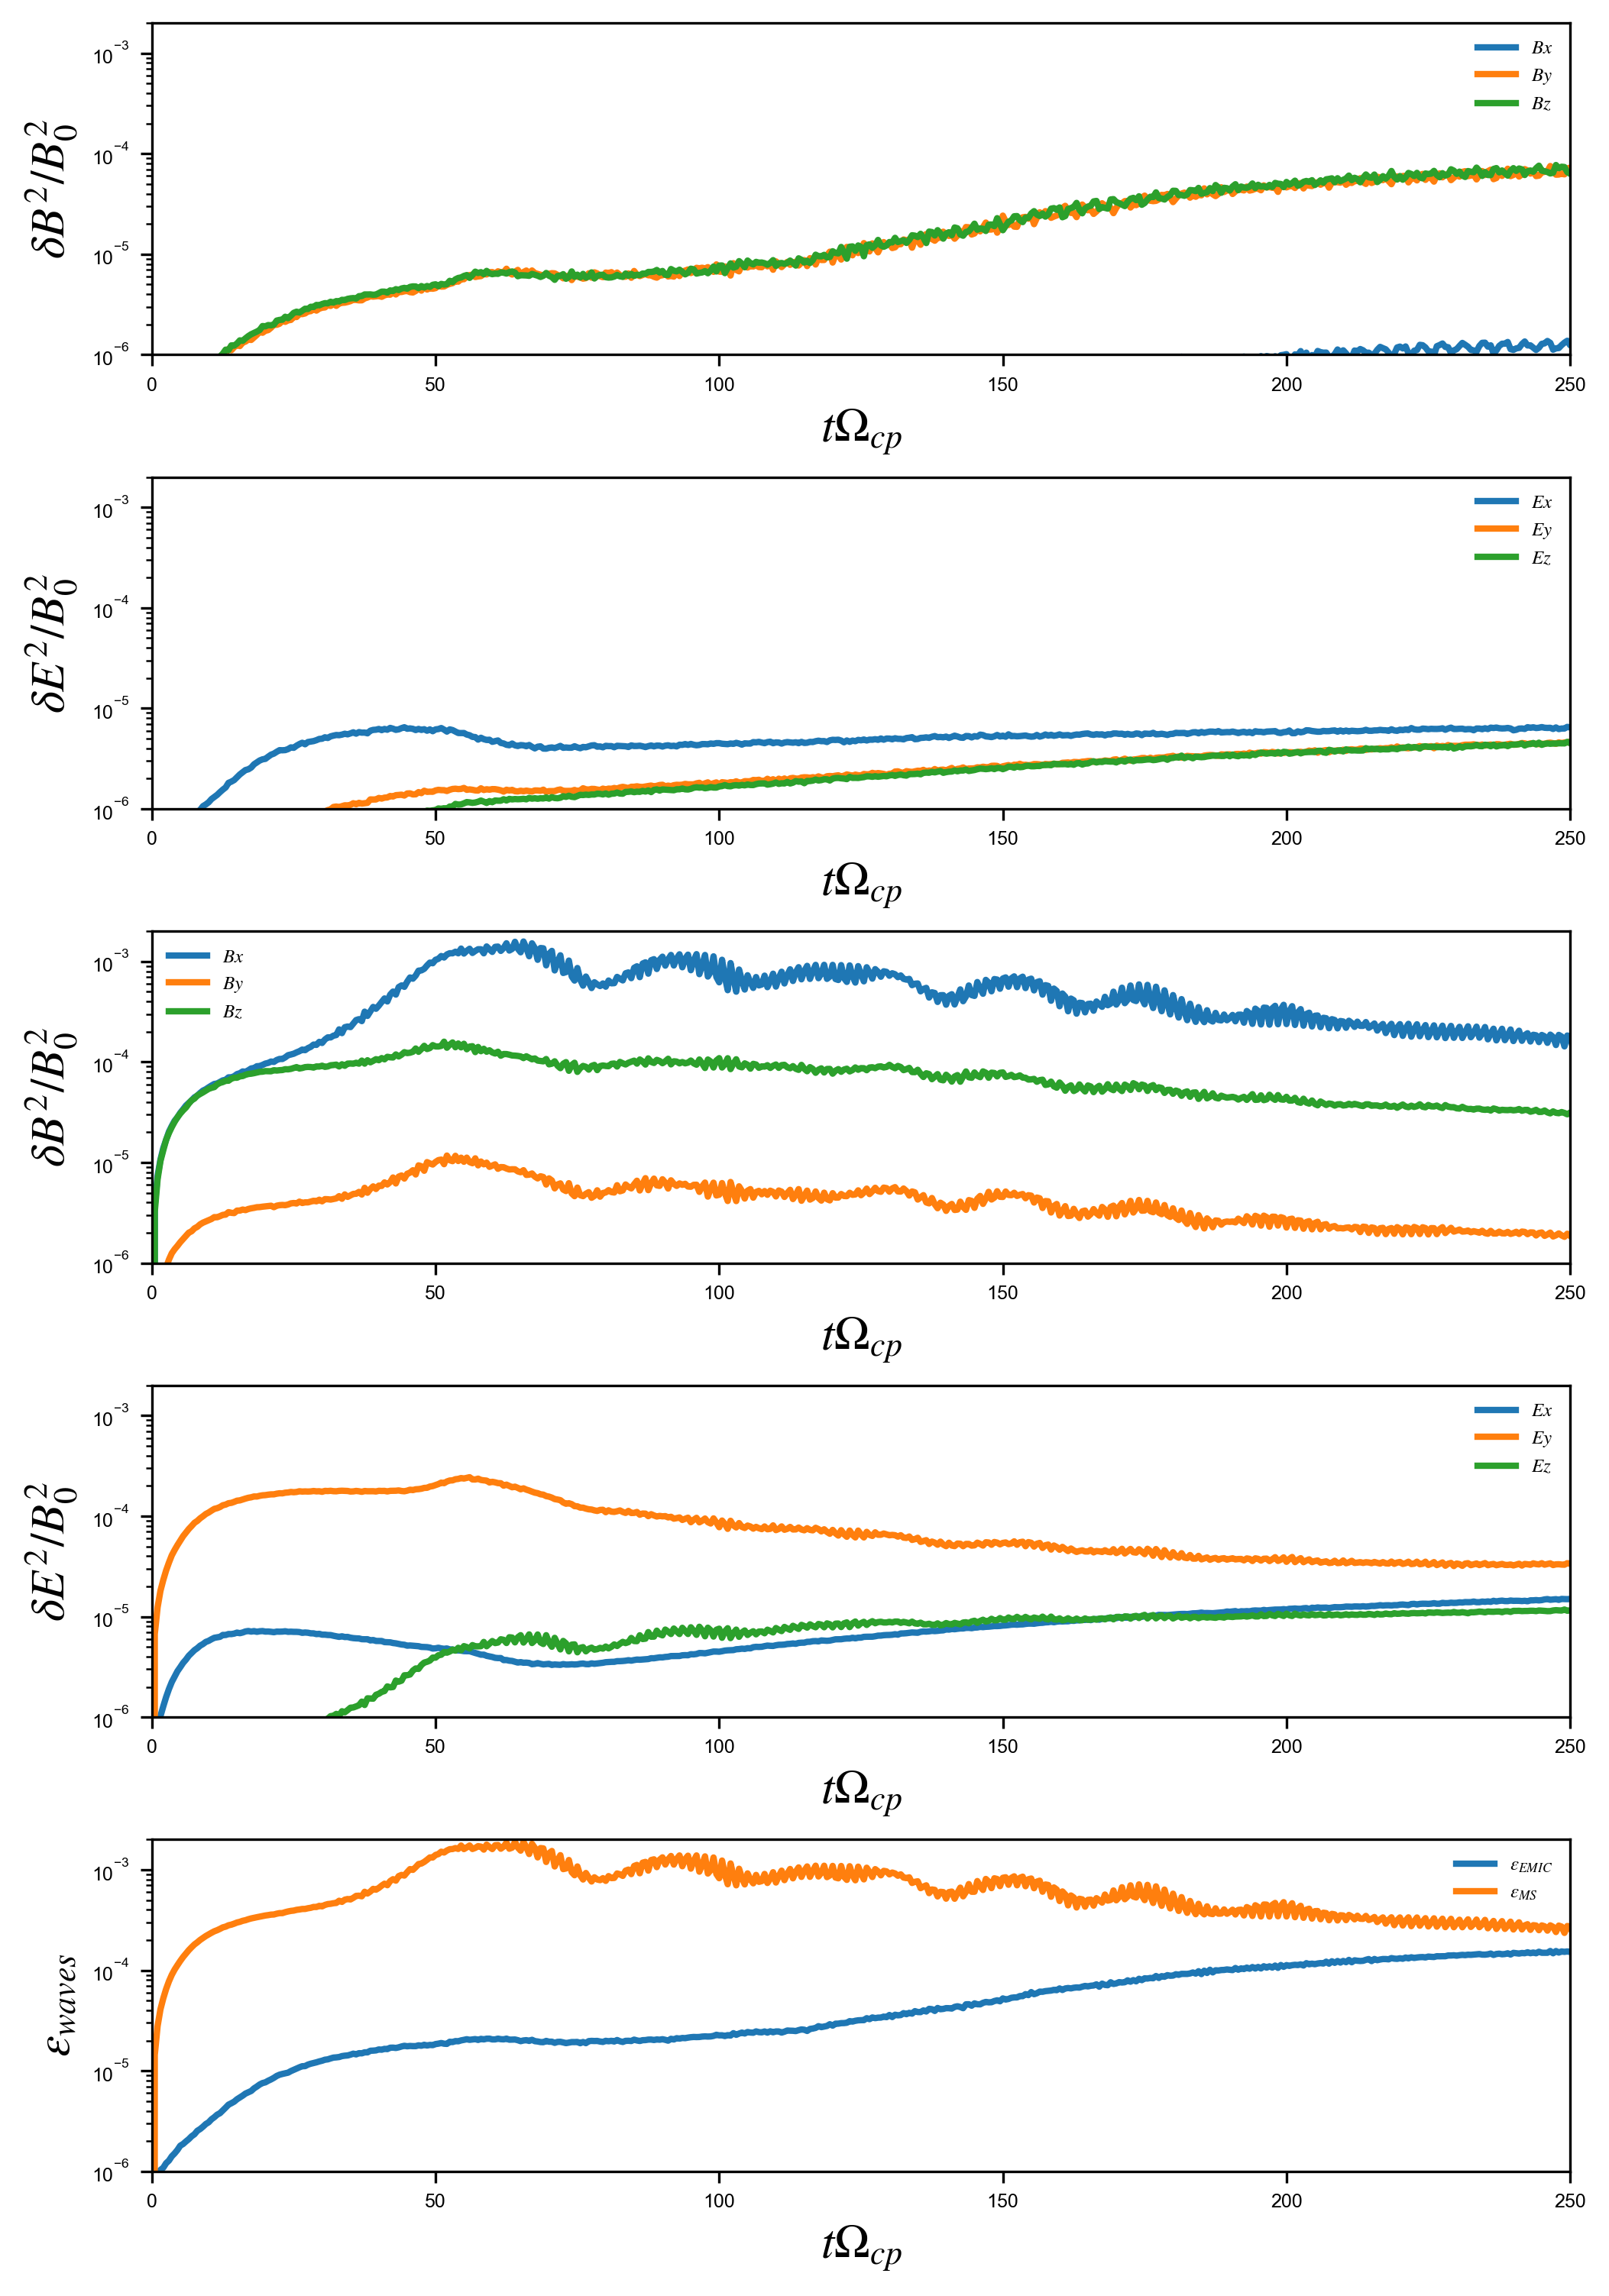

In [41]:
#画图
plt.style.use('paper')
fig,axs = plt.subplots(5,1,figsize=(7,10))

axs[0].set_ylabel('$\delta {B}^{2} / B_{0}^{2}$',fontsize=15)
axs[0].plot(time0, qpara_Bx_pow, lw=2, label='$Bx$')
axs[0].plot(time0, qpara_By_pow, lw=2, label='$By$')
axs[0].plot(time0, qpara_Bz_pow, lw=2, label='$Bz$')

axs[1].set_ylabel('$\delta {E}^{2} / B_{0}^{2}$',fontsize=15)
axs[1].plot(time0, qpara_Ex_pow, lw=2, label='$Ex$')
axs[1].plot(time0, qpara_Ey_pow, lw=2, label='$Ey$')
axs[1].plot(time0, qpara_Ez_pow, lw=2, label='$Ez$')

axs[2].set_ylabel('$\delta {B}^{2} / B_{0}^{2}$',fontsize=15)
axs[2].plot(time0, qperp_Bx_pow, lw=2, label='$Bx$')
axs[2].plot(time0, qperp_By_pow, lw=2, label='$By$')
axs[2].plot(time0, qperp_Bz_pow, lw=2, label='$Bz$')

axs[3].set_ylabel('$\delta {E}^{2} / B_{0}^{2}$',fontsize=15)
axs[3].plot(time0, qperp_Ex_pow, lw=2, label='$Ex$')
axs[3].plot(time0, qperp_Ey_pow, lw=2, label='$Ey$')
axs[3].plot(time0, qperp_Ez_pow, lw=2, label='$Ez$')

axs[4].set_ylabel('$\epsilon_{waves}$',fontsize=15)
axs[4].plot(time0, U_EMIC, lw=2, label='$\epsilon_{EMIC}$')
axs[4].plot(time0, U_MS, lw=2, label='$\epsilon_{MS}$')

for i in range(5):
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e-6,2e-3)
    axs[i].set_xlabel(r'$t\Omega_{cp}$',fontsize=15)
    axs[i].set_xlim(0,250)
    axs[i].legend()

plt.tight_layout()
plt.savefig("./pic/filter_wave_energy01.pdf", dpi=400, bbox_inches='tight')
plt.show()

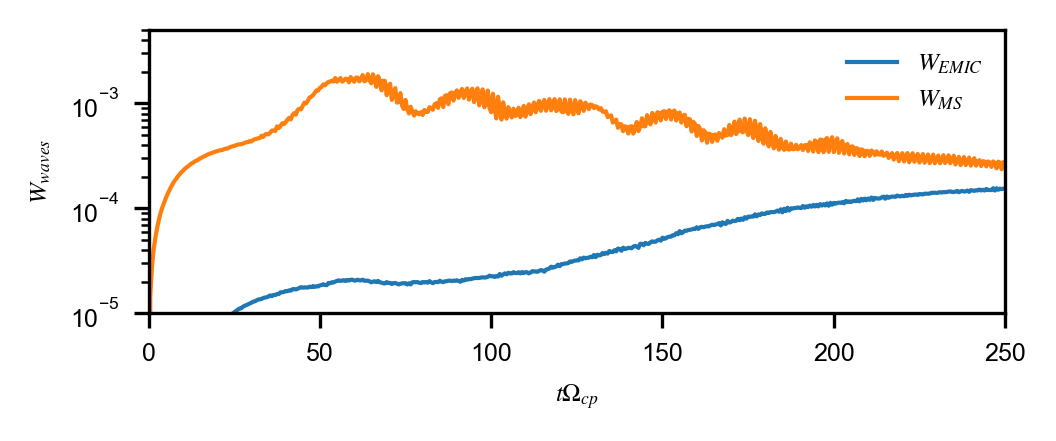

In [45]:
fig,ax = plt.subplots(figsize=(3.5,1.45))
ax.set_ylabel('$W_{waves}$')
ax.plot(time0, U_EMIC, label='$W_{EMIC}$')
ax.plot(time0, U_MS, label='$W_{MS}$')
ax.set_yscale("log")
ax.set_ylim(1e-5,5e-3)
ax.set_xlabel(r'$t\Omega_{cp}$')
ax.set_xlim(0,250)
ax.legend()

plt.tight_layout()
plt.savefig("./pic/tot_filter_wave_energy.png", dpi=400, bbox_inches='tight')
plt.show()

In [43]:
print(np.max(U_MS))
print(np.max(U_EMIC[500]))
print(U_EMIC.shape)
print(np.max(U_EMIC[500])/np.max(U_MS))

0.001900643966686302
0.00015249613489541402
(601,)
0.08023392995653207
